In [1]:
from torch.utils.data import Dataset
import torchvision.transforms.functional as F
from utils.DiceLoss import DiceLoss
from utils.JaccardIndex import JaccardIndex
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import blob_doh, blob_log
from skimage.morphology import dilation, square
from skimage.measure import label, regionprops
import math
import sys
# sys.setrecursionlimit(512 * 512)

In [2]:
imageSize = 256

In [6]:
# Incarcare imagini presegmentate
seg_folder = 'G:/MachineLearning/lesion-database/validation/'
# models = ['DenseNet201', 'Inception', 'ResNet152', 'ResNeXt101', 'Fusion']
models = ['DenseNet201', 'Inception', 'ResNet152', 'ResNeXt101', 'Fusion']
# models = ['UNet', 'Fusion']
seg = np.zeros((len(models), 1507, imageSize, imageSize), dtype=bool)
seg_proc = np.zeros((len(models), 1507, imageSize, imageSize), dtype=bool)
for i in range(len(models)):
    full_path = seg_folder + models[i]
    seg_files = glob.glob(full_path + '/*.ct')
    for j in range(len(seg_files)):
        seg[i, j, :, :] = np.fromfile(seg_files[j], dtype=np.int8).squeeze().reshape([imageSize, imageSize]).astype(bool)
    print(f"Done loading {models[i]}")

seg = torch.tensor(seg)

seg_folder = 'G:/MachineLearning/lesion-database/validation/'
# models = ['DenseNet201', 'Inception', 'ResNet152', 'ResNeXt101', 'Fusion']
for i in range(len(models)):
    full_path = seg_folder + models[i]
    seg_files = glob.glob(full_path + '/*.ct')
    for j in range(len(seg_files)):
        seg_proc[i, j, :, :] = np.fromfile(seg_files[j], dtype=np.int8).squeeze().reshape([imageSize, imageSize]).astype(bool)
    print(f"Done loading {models[i]} post-processed")

seg_proc = torch.tensor(seg_proc)

# Incarcare ground truth
lits_seg = glob.glob('G:/MachineLearning/lesion-database/testing/masks/*.ct')
ground_truth = np.zeros((1507, imageSize, imageSize), dtype=bool)
for j in range(len(lits_seg)):
    ground_truth[j, :, :] = np.fromfile(lits_seg[j], dtype=np.float16).squeeze().reshape([imageSize, imageSize]).astype(bool)
print(f"Done loading ground truth")
ground_truth = torch.tensor(ground_truth)

Done loading DenseNet201
Done loading Inception
Done loading ResNet152
Done loading ResNeXt101
Done loading Fusion
Done loading DenseNet201 post-processed
Done loading Inception post-processed
Done loading ResNet152 post-processed
Done loading ResNeXt101 post-processed
Done loading Fusion post-processed
Done loading ground truth


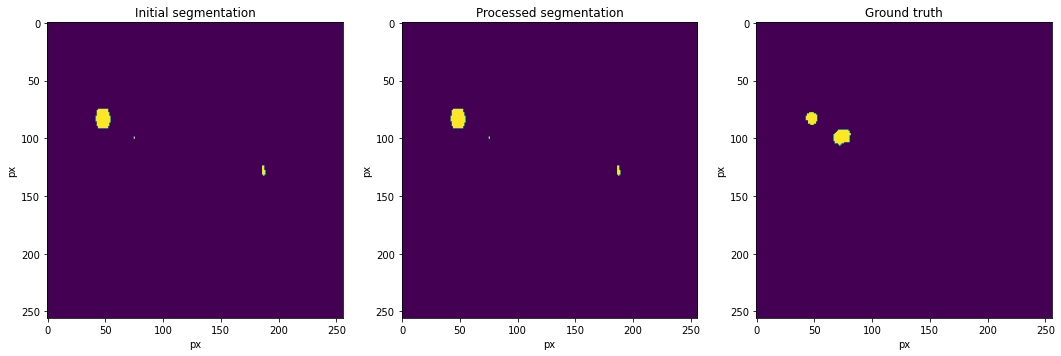

In [7]:
plt.figure(figsize = (18, 10))
slice = 14
ax = plt.subplot(1, 3, 1)
ax.grid(False)
plt.title("Initial segmentation")
plt.xlabel('px')
plt.ylabel('px')
plt.imshow(seg[0, slice, :, :].squeeze())
ax = plt.subplot(1, 3, 2)
ax.grid(False)
plt.title("Processed segmentation")
plt.xlabel('px')
plt.ylabel('px')
plt.imshow(seg_proc[0, slice, :, :].squeeze())
ax = plt.subplot(1, 3, 3)
ax.grid(False)
plt.title("Ground truth")
plt.xlabel('px')
plt.ylabel('px')
plt.imshow(ground_truth[slice, :, :].squeeze())
ax.grid(False)

In [8]:
# Evaluam DICE per case, average dice per slice si Jaccard
dice_loss = DiceLoss()
jaccard = JaccardIndex()

for i in range(len(models)):
    dice = 1.0 - dice_loss(ground_truth, seg[i, :, :, :].squeeze())
    print(f"Dice score average per case for {models[i]}: {dice:.3f}")
print('')

for i in range(len(models)):
    dice = 1.0 - dice_loss(ground_truth, seg_proc[i, :, :, :].squeeze())
    print(f"Dice score average per case for {models[i]}: {dice:.3f}")
print('')

# for i in range(len(models)):
#     dice = 0
#     for s in range(ground_truth.size(dim=0)):
#         dice += (1.0 - dice_loss(ground_truth[s, :, :], seg[i, s, :, :]))
#     dice = dice / ground_truth.size(dim=0)
#     print(f"Dice score per slice average for {models[i]}: {dice:.3f}")
# print('')

# for i in range(len(models)):
#     jcc_score = jaccard(ground_truth, seg[i, :, :, :].squeeze())
#     print(f"Jaccard index average per case for {models[i]}: {jcc_score:.3f}")

Dice score average per case for DenseNet201: 0.701
Dice score average per case for Inception: 0.574
Dice score average per case for ResNet152: 0.751
Dice score average per case for ResNeXt101: 0.746
Dice score average per case for Fusion: 0.758

Dice score average per case for DenseNet201: 0.701
Dice score average per case for Inception: 0.574
Dice score average per case for ResNet152: 0.751
Dice score average per case for ResNeXt101: 0.746
Dice score average per case for Fusion: 0.758



In [ ]:
# Facem diferentele de segmentari
num_models = len(models)
diff_dice = torch.zeros(num_models, num_models)
for i in range(num_models):
    for j in range(num_models):
        diff_dice[i, j] = 1.0 - dice_loss(seg[i, :, :, :] ^ ground_truth, seg[j, :, :, :] ^ ground_truth)
diff_dice = diff_dice.cpu().numpy()

In [ ]:
plt.figure(figsize = (8, 8))
sns.set(font_scale=1.4)
hmap = sns.heatmap(data=diff_dice, annot=True, xticklabels=models, yticklabels=models, square=True, cbar=False, cmap='viridis')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
hmap.set_title("DICE similarity between model errors", fontsize=20)